<a href="https://colab.research.google.com/github/auroramugnai/Minimum-Exact-Cover-Problem/blob/main/MECP_with-QAOA/QAOA_random_parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the MECP with QAOA+ using "Random Parameters" technique

In [2]:
# Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# %cd /content/drive/MyDrive/ICFO_CODICI/progetto/MECP_with-QAOA
# ! pip install -r requirements.txt

## Import Modules & Define Functions

In [1]:
from __future__ import annotations
from utils_to_build_QAOAAnsatz import *

In [2]:
from random_instances import info_dim6

In [3]:
from datetime import datetime
import math
import random
import time

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from scipy.optimize import minimize
from pprint import pprint # to print dictionaries

In [7]:
def write_params_on_file(DATA_FILE, params):
    DATA_FILE.write("\nChosen parameters:\n")
    DATA_FILE.write(f"Number of layers (p): {params['p']}\n")
    DATA_FILE.write(f"Number of random attempts: {params['random_attempts']}\n")
    DATA_FILE.write(f"Initialization type: {params['init_string']}\n")
    DATA_FILE.write(f"Size (n): {params['n']}\n")
    DATA_FILE.write(f"Chosen instances (chosen_instances): {params['chosen_instances']}\n")
    DATA_FILE.write(f"Choices of k (chosen_ks): {params['chosen_ks']}\n")


    # Display the chosen parameters
    print(f"######### ...Writing on file...: #########")
    print("Chosen parameters:")
    print(f"Number of layers (p): {params['p']}")
    print(f"Number of random attempts: {params['random_attempts']}")
    print(f"Initialization type: {params['init_string']}")
    print(f"Size (n): {params['n']}")
    print(f"Chosen instances (chosen_instances): {params['chosen_instances']}")
    print(f"Choice of ks (chosen_ks): {params['chosen_ks']}")
    print(f"##########################################")

## Set Parameters

In [12]:
### Get parameters from the user
params = get_parameters_from_user(info_dim6)

# Get the parameters separately
chosen_instances = params['chosen_instances']
chosen_ks = params['chosen_ks']
p = params['p']
random_attempts = params['random_attempts']
init_string = params['init_string']

n = params['n']

Number of layers (p), default is 4:  
Number of random attempts, default is 50:  
String initialization (all1 or all0), default is all0:  
Size n (6, 8, 10), default is 6:  
Chosen instances, default is [1, ..., 10] (Give a list please!):  [1,2]
Choice for L, to compute k as L/(min_length * n). Give a list specifying L for every instance chosen please. [4,3]


## For Every Instance Chosen, Do the Minimization
This code iterates through selected instances, generating corresponding subsets and computing the spectrum of states, including Minimum Exact Cover (MEC) states. It then builds the quantum circuits for the QAOA+ algorithm, including cost, mixing, and initialization circuits. Initial angles (betas and gammas) are randomly set within specified bounds, and the QAOA+ algorithm is run for multiple random initializations to minimize energy. Results, such as the optimal parameters, best attempt, minimum energy, and elapsed time, are recorded. Final data of each instance is saved in a .csv and a .txt.



Saving in folder_path = random_parameters_2025-06-08@11h47m12s
**************************************************
Instance 1 with h = 0.3333333333333333

U, subsets, EXACT_COVERS, MEC {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12} [{8, 11}, {8, 11, 4, 12}, {10, 3}, {9, 2, 5, 7}, {1, 6}, {4, 12}] ['011110', '101111'] ['011110']


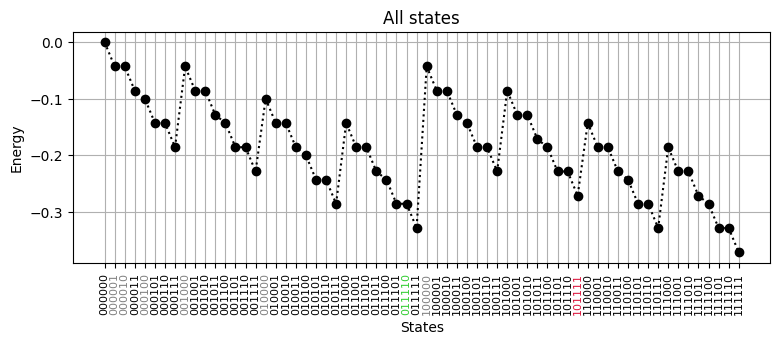

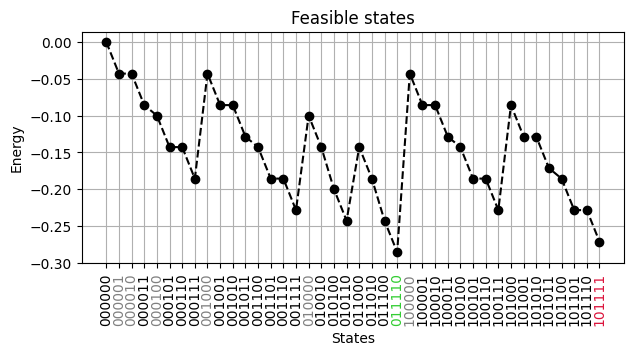

######### ...Writing on file...: #########
Chosen parameters:
Number of layers (p): 4
Number of random attempts: 50
Initialization type: all0
Size (n): 6
Chosen instances (chosen_instances): [1, 2]
Choice of ks (chosen_ks): [0.3333333333333333, 0.25]
##########################################

---------- 1/50 random_attempts -----------

pars_0 = [3.1664035514091533, 0.6738420669382746, 0.9520988712950306, 1.8285337189085213, -2.6181826198240694, -2.6859011929197782, -8.521426189388091, 2.0992404237061617]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.09468645070021714
E_min = result.fun = 0.09102783501406858

Optimal parameters: betas, gammas = [3.9686579123135926, 1.1707531359687255, 1.462068168757108, 2.016011188639814], [-3.780945502251944, 0.00907158686111455, -0.009427848979690292, -0.014001692308014409]
--> ***UPDATING THE BEST ATTEMPT***

   states  counts_p4_1of50
1  010000              684
3  100001              322
0  000001               11
2  100000                7

---------- 2/50 random_attempts -----------

pars_0 = [4.103759183564312, 0.4093723238881072, 3.3523452899351547, 3.43782608243611, 9.448928319184322, 1.2446864401823738, 2.3497626491962027, -0.7576385733089861]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.09832437127480802
E_min = result.fun = 0.0873899144394777

Optimal parameters: betas, gammas = [2.7601684717443744, 1.8436844564495583, 2.452276431054376, 4.4071508453386095], [5.566113713154921, 3.1841585580161302, -0.47360470522571974, -0.6906177027599645]
--> ***UPDATING THE BEST ATTEMPT***

   states  counts_p4_2of50
1  010000              947
3  100001               57
0  000001               15
2  100000                5

---------- 3/50 random_attempts -----------

pars_0 = [4.9428539391697175, 1.1023908985105915, 1.569560125726109, 4.496857988216112, -1.380642646446761, 5.865269593874167, 6.630268499993235, -2.862981463257711]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated successfully.
         Curren

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.0983738341214283
E_min = result.fun = 0.08734045159285742

Optimal parameters: betas, gammas = [2.768689034035529, 1.845123873649389, 2.4311760865291254, 4.424821914720916], [-0.07541462316744615, 7.810112586311758, -1.0497461679261066, -1.6171576251228892]
--> ***UPDATING THE BEST ATTEMPT***

   states  counts_p4_4of50
1  010000              930
3  100001               75
0  000001               12
2  100000                7

---------- 5/50 random_attempts -----------

pars_0 = [1.8173422430766022, 0.9884776426016336, 5.693707672391233, 5.254678240052826, 0.07093037788406953, 7.498089517499601, 0.5064067429539669, -5.71497570393971]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated successfully.
         Curren

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.09999993625970623
E_min = result.fun = 0.0857143494545795

Optimal parameters: betas, gammas = [5.554724711631116, 0.8582855192808208, 6.136899523489517, 1.8798157091370413], [-6.292237982550898, 0.040773972089305416, -0.17800448849115086, 0.12856498117222676]
--> ***UPDATING THE BEST ATTEMPT***

   states  counts_p4_6of50
0  010000             1024

---------- 7/50 random_attempts -----------

pars_0 = [0.83132648614939, 6.2215291629093175, 4.387728831901236, 5.7387523633557205, 2.615081918707059, 3.9911397218944806, 9.601856774401462, -2.7378032011315296]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.09104908808127193
E_min = result.fun = 0.09466519763301379

Optimal parameters: betas, gammas = [0.1632134932255962, 5.532518064094848, 4.243758680415102, 5.930537622644317], [9.995976625058432, 9.995976625058432, -0.9283795767979274, -9.995976625058432]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_7of50
2  010000              604
4  100001              357
0  000000               29
1  000001               20
3  100000               14

---------- 8/50 random_attempts -----------

pars_0 = [0.9393169617747509, 3.4089685995167285, 6.255139402849069, 3.6507923314666786, 5.757721045315918, -8.996243926400233, -2.4142651628020486, -8.235382253786934]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.09840667187554175
E_min = result.fun = 0.08730761383874397

Optimal parameters: betas, gammas = [2.7753806459425934, 1.8611907015427662, 2.4035688639456003, 4.441787978694102], [-9.635288255255224, -9.906079416782273, 1.176076756597694, 1.9228248523535916]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_9of50
1  010000              954
3  100001               58
0  000001                6
2  100000                6

---------- 10/50 random_attempts -----------

pars_0 = [4.186927152144733, 5.645865041102747, 3.092002790952843, 5.432765849273808, 6.458856984474746, -5.560654926074524, 2.692053383959733, 3.034795844510848]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated successfully.
         Curren

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.09999995015587652
E_min = result.fun = 0.0857143355584092

Optimal parameters: betas, gammas = [6.118522819634782, 5.51415020606748, 0.748743703359514, 4.541043503851751], [-7.714000556191427, 0.3421777775213066, 0.08322083062149682, -0.13788015046148783]
--> ***UPDATING THE BEST ATTEMPT***

   states  counts_p4_11of50
0  010000              1024

---------- 12/50 random_attempts -----------

pars_0 = [0.12166929099587225, 4.167903131813077, 4.521767318075857, 1.5197220502094964, 6.637538922177104, 9.845138494285315, 3.76360097122242, -5.8548220041199945]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.09711127353800753
E_min = result.fun = 0.0886030121762782

Optimal parameters: betas, gammas = [0.0, 5.110134670920925, 5.449516001421864, 1.2811364266181842], [7.028485863369474, 8.67521248722992, -5.7653539953510375e-06, 4.472678238110303e-06]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_12of50
1  010000               851
3  100001               160
0  000001                10
2  100000                 3

---------- 13/50 random_attempts -----------

pars_0 = [2.034183173007059, 2.032940341493862, 2.5001139195043085, 5.897996474477724, -6.809769071220077, 3.053843182563293, -5.066176667509713, -5.244985138972142]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.09840186140978976
E_min = result.fun = 0.08731242430449596

Optimal parameters: betas, gammas = [2.7632399258334295, 1.8715447918058876, 2.389436363386025, 4.425798833314106], [-9.949644916388575, 9.989823909560744, -1.3498272652749397, -2.0315693656659617]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_13of50
2  010000               943
4  100001                65
1  000001                 9
3  100000                 6
0  000000                 1

---------- 14/50 random_attempts -----------

pars_0 = [3.0134069542272357, 2.0228666581714405, 2.8074639848829244, 2.8399584008790923, 3.9956096829118852, -9.50403308469414, 4.537513186803338, 2.899738811461443]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization te

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.09377962824797963
E_min = result.fun = 0.0919346574663061

Optimal parameters: betas, gammas = [4.148552436282534, 2.1018335900593375, 2.6640502439017864, 6.283185302462093], [-9.173492809218526, -0.0007852529851743913, -0.000295377706234898, -9.482766830673416]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_16of50
1  010000               635
3  100001               366
0  000001                22
2  100000                 1

---------- 17/50 random_attempts -----------

pars_0 = [3.5270841321235173, 1.0252141229995166, 5.656057426796254, 4.486649819900342, 8.106722598617022, -7.293313327461662, 0.20153854571897156, 0.2840072133052054]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated successfully.

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.09368540929439417
E_min = result.fun = 0.09202887641989155

Optimal parameters: betas, gammas = [4.880438440257928, 2.944849847878867, 4.796439505438766, 3.8699331638320604], [9.671657351335163, 1.2334835726981899, 0.8293852557237942, -7.259273092145843]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_18of50
2  010000               684
4  100001               304
3  100000                14
1  000001                12
0  000000                10

---------- 19/50 random_attempts -----------

pars_0 = [0.6829551908095253, 0.9497608440937585, 2.2416804996780515, 5.096687618257802, 5.294784861045629, 5.5743703041996095, -5.970039463206225, 7.01341450808204]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.08625282445794441
E_min = result.fun = 0.09946146125634131

Optimal parameters: betas, gammas = [0.4513614374171008, 2.173781505453692e-10, 3.2619801938514024, 5.754288398411499], [9.807034615605259, 9.995976625058432, -9.995874604082115, 0.00018156040163836177]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_19of50
3  100001               926
2  010000                89
0  000000                 5
1  000001                 4

---------- 20/50 random_attempts -----------

pars_0 = [5.603935023293629, 4.315041317060594, 0.91682039766104, 0.8113471654943673, -4.423742921547469, -7.578454040584532, 1.6393784395689384, 8.01391879256619]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.0971112735377684
E_min = result.fun = 0.08860301217651732

Optimal parameters: betas, gammas = [5.110133343426231, 5.449510414622933, 2.4393094242702904e-11, 1.2811333834491414], [3.689964606308216, -2.6502616134381214e-05, 4.901740171525587, -4.901733983899422]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_20of50
1  010000               852
2  100001               170
0  000001                 2

---------- 21/50 random_attempts -----------

pars_0 = [3.928893063135793, 5.7541245325544494, 0.536290490497962, 4.054297583815176, 5.442001841166723, 8.695338124690107, -8.115749396864683, -0.3643939607516593]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.09969666229923976
E_min = result.fun = 0.08601762341504596

Optimal parameters: betas, gammas = [0.719240072394659, 6.126512779929422, 1.3520538304343517, 4.962656011354961], [-9.978067930885304, -9.995976432221916, 9.995976625058432, -0.46968110722766526]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_21of50
1  010000              1013
3  100001                 9
0  000001                 1
2  100000                 1

---------- 22/50 random_attempts -----------

pars_0 = [4.183932448742557, 1.6386603354201361, 1.1798758877024356, 6.089138413171689, 5.6988405207076465, 1.861310458952861, 4.19184522361741, 9.226400442201012]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated successfully.
         

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.09832278715677704
E_min = result.fun = 0.08739149855750868

Optimal parameters: betas, gammas = [2.754987630617753, 1.8439390822296013, 2.457811692002795, 4.4024380929569205], [8.256601840251772, 2.989012104619392, -0.5091911201819039, -0.735842124273907]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_23of50
1  010000               943
3  100001                69
0  000001                10
2  100000                 2

---------- 24/50 random_attempts -----------

pars_0 = [4.152833675169721, 1.8572598683713308, 2.7061657488979654, 0.6594003769235064, -8.237081493762995, 6.069212321955497, 9.709845102816672, 6.949940841289148]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.09643557890267751
E_min = result.fun = 0.08927870681160821

Optimal parameters: betas, gammas = [4.081888499530271, 1.4306753773886751, 2.57310119708317, 0.8358949782209764], [9.847042904266145, 9.990040686220956, 9.99535537183165, 9.56288932665979]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_24of50
1  010000               816
3  100001               196
0  000001                 6
2  100000                 6

---------- 25/50 random_attempts -----------

pars_0 = [3.80398419886073, 0.9581692287935955, 3.052334997594543, 2.365775694158794, -2.114619869871884, -0.19486182883750125, -6.02927063876856, -6.010286119977248]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.09577041556006623
E_min = result.fun = 0.0899438701542195

Optimal parameters: betas, gammas = [4.019259849238853, 1.4005800084337565, 2.7329656456578295, 0.8202995668402853], [8.635794093590725, -1.3616195854520958, -1.8962106915359618, -1.5431221741884507]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_25of50
2  010000               771
3  100001               246
1  000001                 6
0  000000                 1

---------- 26/50 random_attempts -----------

pars_0 = [1.5390407555962216, 2.6830340135944217, 0.733444190330308, 0.01712526138108567, -5.798135261168624, -1.6311950645695834, 0.6477459623241515, 6.193810164952804]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.08571428571428438
E_min = result.fun = 0.10000000000000134

Optimal parameters: betas, gammas = [3.1415917592075937, 3.306456536515123e-07, 3.887338116577426e-08, 1.8867388662808496e-07], [-9.752836884554387, -3.7122540940061466, -0.17853208039812488, 6.782796041351517]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_26of50
0  100001              1024

---------- 27/50 random_attempts -----------

pars_0 = [2.2760547724729623, 3.077522967426788, 1.4715505238843967, 2.535617598540221, 8.734474513175762, 4.2503374613543485, -0.727515347143779, 7.372016253942373]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.09377962826972625
E_min = result.fun = 0.09193465744455948

Optimal parameters: betas, gammas = [0.0, 4.148567771721391, 2.1017787595460877, 2.664116798972933], [9.972314838542882, 9.995976625058432, 0.0005971604603770362, 0.00014451536300287733]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_27of50
1  010000               609
2  100001               398
0  000001                17

---------- 28/50 random_attempts -----------

pars_0 = [1.959609514253159, 0.7359342616356379, 3.1078952221979548, 4.542515086049682, -9.873830624320796, 8.757566560440598, -3.7730899346453857, 2.985043354491811]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated successfully.
         Current function value: 0.087305
  

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.09991918626010507
E_min = result.fun = 0.08579509945418065

Optimal parameters: betas, gammas = [5.56122011491955, 0.8113665070430525, 4.314607049320545, 6.282799751533986], [8.661196558311126, -0.004181988416104412, 0.004459817322965097, -3.874714769539187]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_30of50
0  010000              1020
1  100001                 4

---------- 31/50 random_attempts -----------

pars_0 = [2.4421501960857395, 5.026180916519916, 2.108260040688914, 5.995309144227421, -8.372084762675492, -4.642058755365873, 2.4614887249799082, 4.743222640392512]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.09997367243693223
E_min = result.fun = 0.0857406132773535

Optimal parameters: betas, gammas = [0.6029919805478134, 6.052209614985497, 1.2641937383800368, 4.889824740332024], [9.995976625058432, 1.3624161181055312, -0.6461121655048552, 0.05038095771708531]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_31of50
0  010000              1024

---------- 32/50 random_attempts -----------

pars_0 = [5.64209560355371, 5.238973971934455, 2.784080119740936, 3.2524069085499026, 8.024971464493564, -7.8860065726796185, -7.571353962573186, 9.99131391624217]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated successfully.
         Current function value: 0.100000
         Iterations: 247
         Function evaluati

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.08625439322894606
E_min = result.fun = 0.09945989248533967

Optimal parameters: betas, gammas = [0.10162567317746515, 0.35531710845899034, 3.258471262262855, 5.747533452261903], [-8.442329450493844, 1.7059025438010589, -0.3852978385617827, 0.0574990334966467]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_36of50
4  100001               945
2  010000                68
0  000000                 9
1  000001                 1
3  100000                 1

---------- 37/50 random_attempts -----------

pars_0 = [1.1628511357927453, 5.056733313794354, 4.345743175309281, 2.033027686279269, 8.205505839658677, 4.410952603284851, 3.1881518290002795, -2.476467885626806]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization te

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.0984268968001203
E_min = result.fun = 0.08728738891416542

Optimal parameters: betas, gammas = [5.684095621982689, 4.910918379533161, 5.736922195380821, 0.7313443790844525], [-9.354471070466136, -0.6925421322974208, -0.316629857370301, 0.7530791178535718]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_38of50
1  010000               920
3  100001                95
2  100000                 8
0  000000                 1

---------- 39/50 random_attempts -----------

pars_0 = [1.966562802572323, 0.6378360187880127, 0.14233812737115883, 0.5649158137878337, -4.79484479874547, -6.708769603695318, 4.963473644947626, 1.0215482050589042]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.08662248629865037
E_min = result.fun = 0.09909179941563535

Optimal parameters: betas, gammas = [1.0072680669957323, 1.1756613389708153, 0.14717389791445123, 0.6394425852315666], [-1.06935380785443, -9.995976625058432, 9.995976625058432, 9.851023934227232]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_39of50
4  100001               763
2  010000               225
3  100000                17
0  000000                13
1  000001                 6

---------- 40/50 random_attempts -----------

pars_0 = [3.080692238951049, 2.332801485062553, 6.189119956193751, 3.6102338679836268, -5.0555488327353375, 1.6376556621884308, -7.027765191858034, 3.8713991583396865]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.09486562668086541
E_min = result.fun = 0.0908486590334203

Optimal parameters: betas, gammas = [4.012395931216149, 2.4080144172877125, 6.002171536773856, 3.9302168222919054], [-2.223414590589204, 9.995976625058432, 9.953672271466182, -0.87135630689728]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_40of50
2  010000               797
4  100001               204
0  000000                14
3  100000                 8
1  000001                 1

---------- 41/50 random_attempts -----------

pars_0 = [1.5703163824684634, 5.808653817475428, 3.4126267233091037, 6.114946728954608, 6.168365149368189, 8.237835414006831, 0.8887790008690928, -0.27182384402692783]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.096352261995577
E_min = result.fun = 0.08936202371870872

Optimal parameters: betas, gammas = [4.454201161057475e-05, 5.312772374949464, 4.702813428671398, 5.434108987456602], [7.296747140018421, 9.400276632120981, 0.009449663279268408, -0.05921164016613365]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_41of50
2  010000               939
3  100000                54
4  100001                25
0  000000                 3
1  000001                 3

---------- 42/50 random_attempts -----------

pars_0 = [3.492996342522588, 3.7429211458303446, 2.720270428484864, 4.960671881132828, -8.299061076039383, -1.5583955387504869, -0.560734892797722, 5.978341023073719]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization t

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.09483926554614353
E_min = result.fun = 0.0908750201681422

Optimal parameters: betas, gammas = [4.026148973237342, 2.4260339932675548, 6.002609265576595, 3.9467810720040006], [-1.445435397691413, 9.834930370173915, 9.442878014775864, -0.9145864359266884]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_43of50
1  010000               765
3  100001               236
0  000000                17
2  100000                 6

---------- 44/50 random_attempts -----------

pars_0 = [1.897548603182919, 2.2506781910174016, 2.985551407598212, 0.5535361845164251, 2.2196453856428313, -8.83056106681902, 4.2506904547725455, 8.06932017571128]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated successfully.
         C

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.08587400468061586
E_min = result.fun = 0.09984028103366986

Optimal parameters: betas, gammas = [3.6014847482805887, 5.815428854590758, 3.3567590621554952, 3.4504397004804463], [9.56206834157689, 4.169473683510265, -9.995482285050599, 9.992859206951849]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_45of50
3  100001               986
1  010000                35
2  100000                 2
0  000001                 1

---------- 46/50 random_attempts -----------

pars_0 = [4.736541135764259, 2.6666034943501935, 2.2083694220530985, 4.587156119508565, 7.163047792809099, -3.0467609723114633, 1.6495720425217542, -6.284606783452622]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.09377960293687611
E_min = result.fun = 0.09193468277740961

Optimal parameters: betas, gammas = [6.283185230807668, 4.148580518315015, 2.1017144175047084, 2.6634867689347512], [-9.995976625058432, -9.496714651181938, 0.026906953587822788, -0.0017495280187090163]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_46of50
1  010000               639
2  100001               367
0  000001                18

---------- 47/50 random_attempts -----------

pars_0 = [5.270747020958468, 2.435297390581289, 5.808213019873734, 5.358550842248613, -0.9157927157680206, -5.878606389050793, -9.92016055125865, 6.226585661892059]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.09998295496047249
E_min = result.fun = 0.08573133075381323

Optimal parameters: betas, gammas = [5.7945552029466185, 5.293618554964283, 5.335897382222701, 5.384619339258574], [1.7167163334606785, -0.044109010046513686, -0.559932712953779, 0.8204024723804233]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_47of50
0  010000              1024

---------- 48/50 random_attempts -----------

pars_0 = [1.7715800420093717, 0.3562531995934719, 4.161317787630852, 1.9041549727251659, -2.376266812046838, -0.037187702881743334, 1.201491957497172, 4.286663721447752]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.0922873534896676
E_min = result.fun = 0.09342693222461812

Optimal parameters: betas, gammas = [0.695543729983968, 1.0098887129133343, 6.126443909752723, 1.2324951590778719], [-8.645406453539838, -0.19059558150697645, 0.4882320765374567, -0.2994791444481388]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_48of50
2  010000               512
4  100001               490
3  100000                16
0  000000                 3
1  000001                 3

---------- 49/50 random_attempts -----------

pars_0 = [0.6393407838015521, 0.8297004935690566, 4.724394845479793, 4.612062283071402, -2.8075503266408397, 6.56873332152842, 6.901620006888447, 9.851294938082095]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization ter

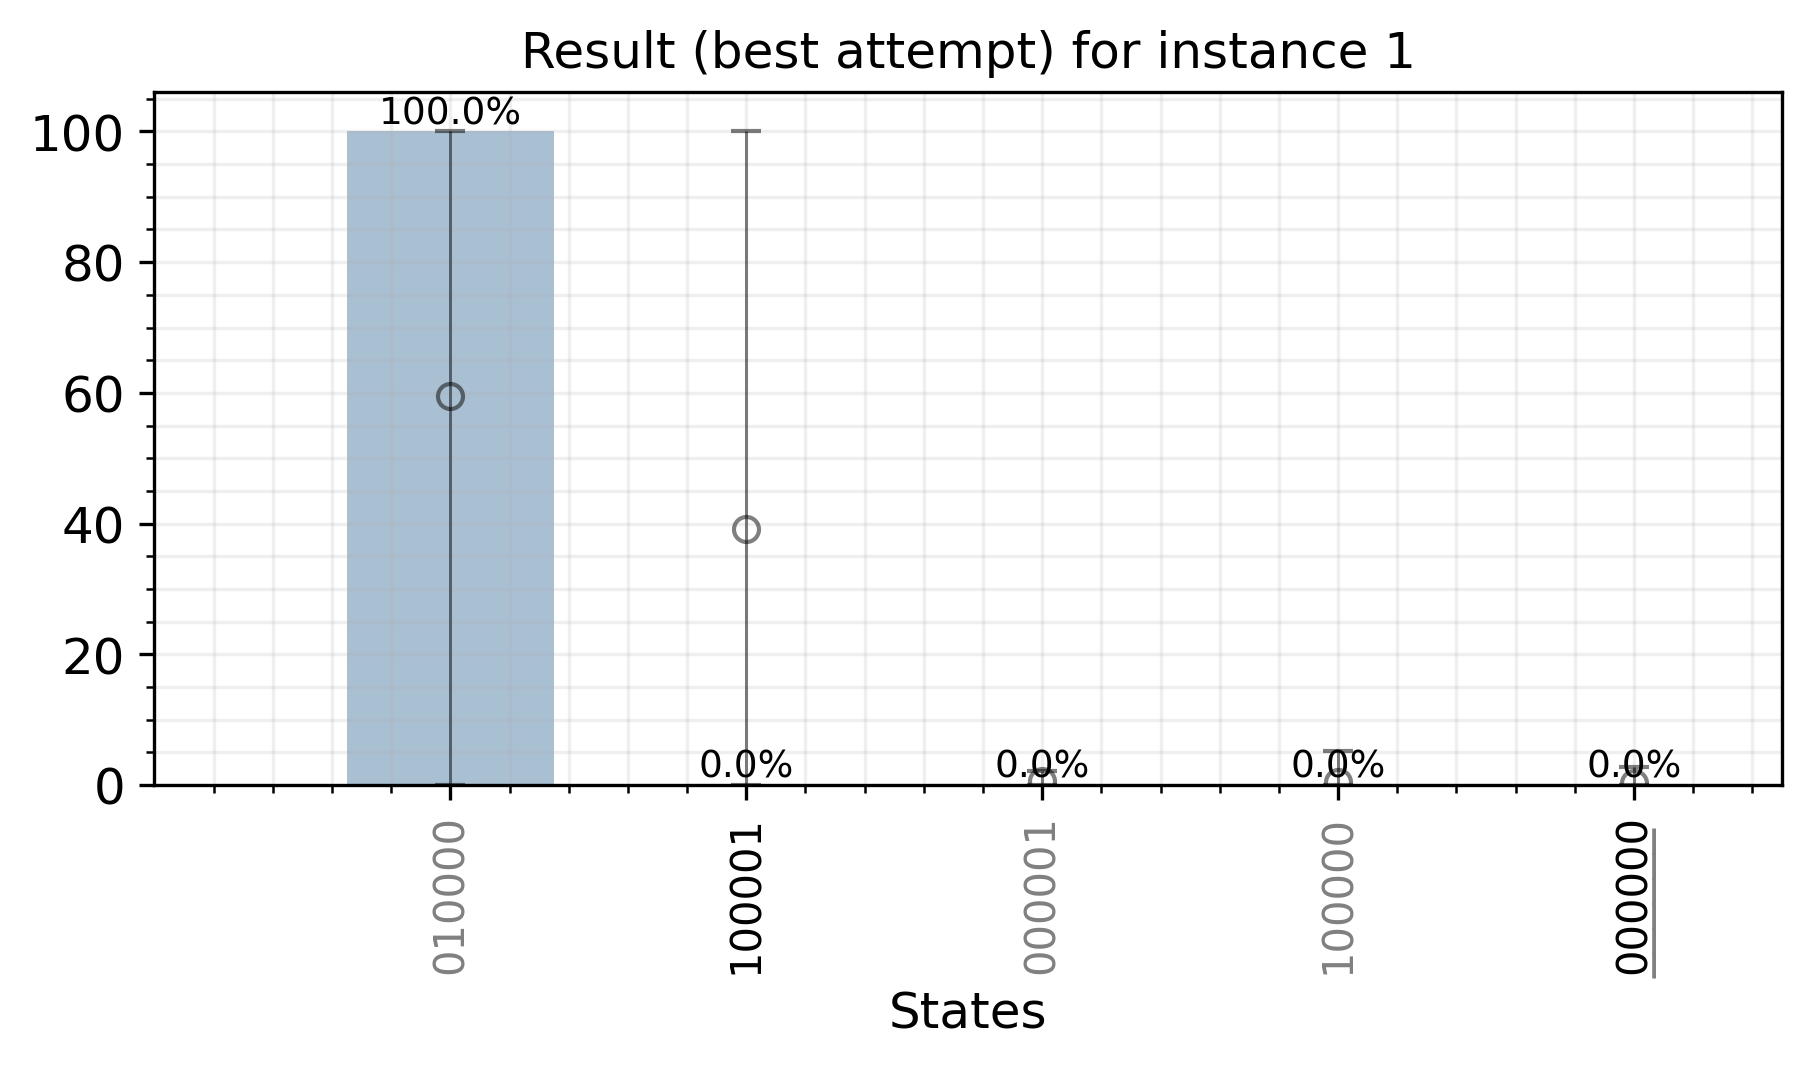

Result saved in:
random_parameters_2025-06-08@11h47m12s/dim6_mail1_all0_random_p4_50ra_k0.3333333333333333_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432].csv
random_parameters_2025-06-08@11h47m12s/dim6_mail1_all0_random_p4_50ra_k0.3333333333333333_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432]_data.txt

TOTAL ELAPSED TIME: 10.507010277112325 minutes.
**************************************************
Instance 2 with h = 0.25

U, subsets, EXACT_COVERS, MEC {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12} [{1, 5}, {4, 6}, {10, 7}, {1, 2, 4, 5, 6, 12}, {2, 12}, {8, 9, 3, 11}] ['001101', '111011'] ['001101']


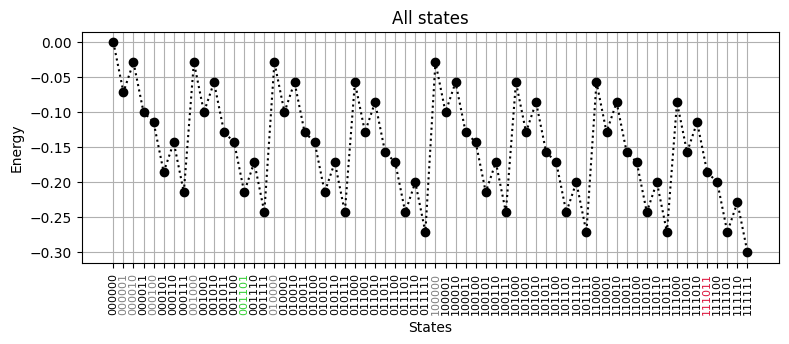

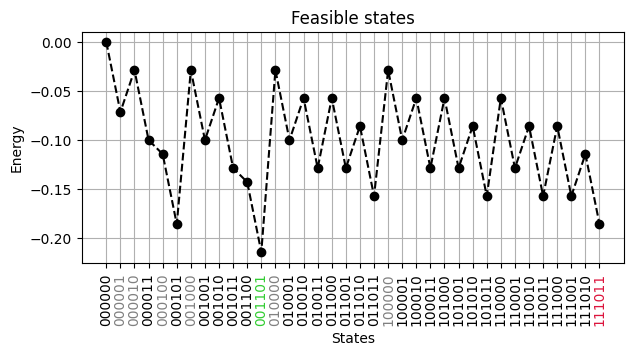

######### ...Writing on file...: #########
Chosen parameters:
Number of layers (p): 4
Number of random attempts: 50
Initialization type: all0
Size (n): 6
Chosen instances (chosen_instances): [1, 2]
Choice of ks (chosen_ks): [0.3333333333333333, 0.25]
##########################################

---------- 1/50 random_attempts -----------

pars_0 = [2.9580854311958182, 2.224992201979154, 5.630868001831532, 3.532947856547284, -5.9277502567174905, 5.651859657644518, -1.5737066624485916, -1.5795767564683754]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated successfully.
         Current function value: 0.064286
         Iterations: 350
         Function evaluations: 555
E_min = result.fun + constant = -0.08571428571426812
E_min = result.fun = 0.064285

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.1000315810003746
E_min = result.fun = 0.04996841899962542

Optimal parameters: betas, gammas = [4.816482203591811, 2.055667661365762, 6.080294857734959, 4.099259377309255], [-9.970097276764479, -9.994858234288948, 3.100121490499607, -9.985303943584235]
--> ***UPDATING THE BEST ATTEMPT***

   states  counts_p4_2of50
2  000100              700
8  110010              200
6  100010               51
4  010010               38
1  000010               20
0  000000                8
3  010000                3
7  110000                3
5  100000                1

---------- 3/50 random_attempts -----------

pars_0 = [3.1410095008481145, 0.6345555637435795, 4.453115368146952, 4.812878723975242, -5.345085963562958, 7.015082294847176, 6.608919696870011, 1.5369048430480152]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.11055079305911221
E_min = result.fun = 0.03944920694088781

Optimal parameters: betas, gammas = [1.5313536671661483, 4.67551253036722, 3.130921538167806, 3.0836564778973727], [-9.89020147452732, 0.0774460261569472, -9.995967364179798, 5.822524323101819]
--> ***UPDATING THE BEST ATTEMPT***

   states  counts_p4_4of50
1  000100              966
6  110000               52
4  100000                2
0  000010                1
2  010000                1
3  010010                1
5  100010                1

---------- 5/50 random_attempts -----------

pars_0 = [3.517144073687914, 2.664989554374423, 1.7812348166380896, 4.025386673418997, -5.472002896681494, 8.212229186572863, 0.7646853239584175, 5.106561873093387]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432,

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.06883389638961682
E_min = result.fun = 0.0811661036103832

Optimal parameters: betas, gammas = [1.1309395847583494, 0.9923460767302523, 4.825571233230949, 4.795921467527307], [-9.960545396414158, -9.995230633814923, -9.995342507427406, -9.995707836148945]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_8of50
2  000100              315
1  000010              207
8  110010              175
5  100000               97
3  010000               93
7  110000               45
4  010010               38
6  100010               34
0  000000               20

---------- 9/50 random_attempts -----------

pars_0 = [5.129735515169322, 3.529019340832521, 4.699429244703018, 2.81911770196113, 3.6922452893960536, -6.792096072869578, 5.671883148725604, -2.401524070827322]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.10012750762282112
E_min = result.fun = 0.049872492377178904

Optimal parameters: betas, gammas = [4.855982296598551, 2.027805976231731, 6.056147356497142, 4.072008920998083], [-2.102900581601368, -9.944956671978836, 2.909660997189171, -9.987547839770059]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_9of50
2  000100              682
8  110010              188
4  010010               50
6  100010               44
1  000010               25
0  000000               15
7  110000               15
3  010000                3
5  100000                2

---------- 10/50 random_attempts -----------

pars_0 = [1.4003521368713059, 6.184323494269431, 6.0114487301428, 1.343082194919306, 6.954016771182346, 4.233298897616056, 7.207938709961997, -7.350720228570309]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.08717534452926398
E_min = result.fun = 0.06282465547073604

Optimal parameters: betas, gammas = [0.6964631267537331, 2.4400802894555493, 3.41293505323478, 2.8301410188977894], [-1.6411728574396254, -0.6330694067745112, -9.9959640412767, 1.9014344436975164]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_12of50
5  110010               936
2  000100                78
0  000000                 4
4  110000                 3
1  000010                 2
3  100000                 1

---------- 13/50 random_attempts -----------

pars_0 = [0.06621268442329994, 3.576413265015469, 1.55189775236584, 0.9375820518569064, 3.8455239014432188, -0.08994643068005459, -3.6434761957014405, -3.1990648184720483]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.99

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.08578468471880966
E_min = result.fun = 0.06421531528119036

Optimal parameters: betas, gammas = [0.15607577936036032, 6.283185307171932, 2.607578958727042, 0.6829751737150769], [0.9764960292032336, -0.12456073992669678, 0.12456399601859575, 8.16301065537558e-06]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_13of50
2  110010              1016
1  000100                 6
0  000000                 2

---------- 14/50 random_attempts -----------

pars_0 = [1.6946379253548336, 2.930807961608154, 3.699939401564215, 6.144009797026774, 2.8649977834208293, -5.9041276533708436, -4.159192953282089, 9.003426706797871]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.08578052920802659
E_min = result.fun = 0.06421947079197343

Optimal parameters: betas, gammas = [2.852042117781533, 2.2037183028753704, 4.752802350301789, 5.861723070435555], [5.106422268949096, 9.995426190742766, 2.839328933293176, -0.3690060373160796]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_14of50
5  110010              1008
0  000100                 9
1  010000                 3
4  110000                 2
2  010010                 1
3  100010                 1

---------- 15/50 random_attempts -----------

pars_0 = [4.4677204493777145, 1.5088925154441133, 0.4981486187425621, 5.500553510378472, 0.1699414609073724, -2.045170050083125, 5.44404204909096, 3.8927502874077042]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.9959766250

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.09386811949988927
E_min = result.fun = 0.05613188050011075

Optimal parameters: betas, gammas = [4.937394791886902, 1.5922014851322792, 0.0, 3.675599375998291], [5.652652495640076, -9.995976625058432, -8.499729383322613, -6.46070130555213]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_15of50
2  000100               504
8  110010               377
7  110000               117
0  000000                12
1  000010                 4
6  100010                 4
3  010000                 2
4  010010                 2
5  100000                 2

---------- 16/50 random_attempts -----------

pars_0 = [1.834864109395351, 5.209630126571531, 2.3604118801877894, 3.4076226697412317, -7.700367464042801, 1.9215072839245178, 5.50414677748533, 4.100585080078357]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.99

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.11055077046410094
E_min = result.fun = 0.03944922953589908

Optimal parameters: betas, gammas = [1.5311334416352262, 4.675489614573856, 3.1308387321149422, 3.083562564561321], [9.995976625058432, 0.08446920834631666, -9.988588958121209, 5.822736086296844]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_16of50
2  000100               953
6  110000                57
3  010000                 5
1  000010                 3
5  100010                 3
4  010010                 2
0  000000                 1

---------- 17/50 random_attempts -----------

pars_0 = [1.0373581058056267, 2.544256504551048, 1.3870942677600666, 5.0730381739415344, 2.758682457147769, -9.753286622906526, -8.337060600153691, 6.339345066242057]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.11055079289263456
E_min = result.fun = 0.03944920710736546

Optimal parameters: betas, gammas = [1.5313277095718474, 4.675521028728541, 3.1309020871081943, 3.083689701518513], [-2.776330504692366, 0.07791339044531351, -9.995976625058432, 5.837817073994125]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_17of50
2  000100               969
5  110000                51
0  000000                 1
1  000010                 1
3  010000                 1
4  010010                 1

---------- 18/50 random_attempts -----------

pars_0 = [6.027511143169922, 5.334496790480392, 4.528133389669043, 0.8286667732759775, -8.77153600210799, -8.72793168523524, 6.599535544032719, -9.314274271747708]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.9959766250

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.11054649728919348
E_min = result.fun = 0.03945350271080654

Optimal parameters: betas, gammas = [1.5338937033596562, 4.674084553658767, 3.132870218588301, 3.0847364096845853], [9.768315818321154, -0.15166717992837048, 9.653719307557719, -3.4660343513948515]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_21of50
2  000100               957
6  110000                55
1  000010                 4
3  010000                 4
0  000000                 2
4  010010                 1
5  100000                 1

---------- 22/50 random_attempts -----------

pars_0 = [4.121793184422471, 1.3061840072632578, 2.6100610248628575, 5.188840837926648, -2.25169374066627, -3.4723369195618874, 5.3855087040514, -3.643145076327455]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.08717503079592778
E_min = result.fun = 0.06282496920407224

Optimal parameters: betas, gammas = [0.6955841810508696, 2.4401153250602885, 3.4136799255890953, 2.829430111566971], [-5.910133661034976, -0.7666933145977577, -9.988953034742902, 2.0228177745216236]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_24of50
4  110010               933
2  000100                79
1  000010                 5
3  110000                 4
0  000000                 3

---------- 25/50 random_attempts -----------

pars_0 = [5.106680360447515, 1.3303554525958856, 5.990878009787828, 3.4323351475319632, 6.608042778992374, -4.955358447406701, 1.4688950691549927, 9.843053636837475]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.10014270431240549
E_min = result.fun = 0.04985729568759453

Optimal parameters: betas, gammas = [4.858808120335176, 2.013892399290049, 6.065586795613742, 4.075842634288639], [9.995976625058432, 9.993036608380674, -2.672128205253487, 9.992845785673317]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_25of50
2  000100               732
7  110010               175
3  010010                36
5  100010                32
1  000010                30
0  000000                10
6  110000                 8
4  100000                 1

---------- 26/50 random_attempts -----------

pars_0 = [2.8892737556163444, 0.014291330444309285, 2.2674536677694106, 0.8067528664998798, 5.0904374450121015, 8.339167754474214, 8.205598493887464, 0.6860448397205694]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.9959766250584

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.08715320036888745
E_min = result.fun = 0.06284679963111257

Optimal parameters: betas, gammas = [0.6860181005003132, 2.4664539429735335, 3.368864954759923, 2.8725149180405545], [-0.21044476098607678, 0.5436209599216602, 0.8527410389855743, -0.8958857419134625]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_27of50
4  110010               945
2  000100                68
0  000000                 4
3  110000                 4
1  000010                 3

---------- 28/50 random_attempts -----------

pars_0 = [0.1719439849488344, 2.835320417346133, 5.516784759343593, 4.061372198441593, 0.25577345080940894, 1.4854328619939778, 3.348857180753159, -1.9923052846569647]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.08663245051534377
E_min = result.fun = 0.06336754948465625

Optimal parameters: betas, gammas = [0.5815434144686307, 2.7623642677636813, 2.7959418153480478, 3.3330404501269317], [-9.995976625058432, -0.4376547137035653, 4.734572897590521, -2.329871067508809]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_28of50
4  110010               949
2  000100                64
0  000000                 5
1  000010                 5
3  110000                 1

---------- 29/50 random_attempts -----------

pars_0 = [2.78313503188807, 0.9118623478556572, 3.551849807943101, 5.808970586922833, -5.762663536721041, 0.1271277240815465, 9.730368504250322, -5.353069017661791]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.08576951004598958
E_min = result.fun = 0.06423048995401044

Optimal parameters: betas, gammas = [2.8572433894594695, 2.0805955306636568, 4.853472167690224, 5.89428215127074], [-7.3651280272710835, 0.11750372109605806, -0.11157973594491621, 0.8867350298967804]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_29of50
4  110010              1017
0  000100                 4
1  010000                 1
2  100000                 1
3  110000                 1

---------- 30/50 random_attempts -----------

pars_0 = [3.1819091814667444, 4.382184816159559, 0.47808241275902846, 0.8898730932563697, 3.4557931095231744, -4.6688973653685695, 1.4383113082538106, -4.606146953339744]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.08574233949745323
E_min = result.fun = 0.06425766050254679

Optimal parameters: betas, gammas = [3.2245535020426903, 4.690391174773722, 0.7169685444818608, 0.7967241717433176], [7.2193863767706965, 7.9332906291148575, 2.1894656241303263, -2.2795456456145944]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_30of50
1  110010              1022
0  000100                 2

---------- 31/50 random_attempts -----------

pars_0 = [6.182563339283394, 2.928582980260818, 5.57029469959294, 1.7170194965424133, -6.139044359131521, -8.873629394001004, -0.32062616176888525, -3.801378360670923]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated successfully.
         Current function value: 0.064286
         Iteratio

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.11055079260415471
E_min = result.fun = 0.03944920739584531

Optimal parameters: betas, gammas = [1.531337049026876, 4.6754899800882885, 3.1310069470890944, 3.0836634691091205], [-0.8720850745488924, 0.07719519935372321, -9.995976625058432, 5.83684495523722]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_32of50
1  000100               971
6  110000                44
0  000000                 2
2  010000                 2
3  010010                 2
4  100000                 2
5  100010                 1

---------- 33/50 random_attempts -----------

pars_0 = [3.1818433710507072, 4.904577681870815, 1.1402800435100544, 1.1868868695420303, 3.8844157123167857, 0.6086697002513208, 8.870908280872037, -7.918465310632398]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), 

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.08573800560269332
E_min = result.fun = 0.0642619943973067

Optimal parameters: betas, gammas = [3.225177196746876, 4.692284908907329, 0.773075445628737, 0.7421716059602423], [6.162835507941011, 4.350379803928842, 3.763801303183394, -5.224391799238148]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_33of50
2  110010              1016
0  000100                 7
1  010000                 1

---------- 34/50 random_attempts -----------

pars_0 = [2.5303346039244907, 4.500980940137318, 3.2226017334220853, 2.908454075363222, -0.5960136389451023, 9.161541058765842, 4.298396585348664, 6.060971282216013]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]



/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.11054073280904536
E_min = result.fun = 0.03945926719095466

Optimal parameters: betas, gammas = [1.5271013222184893, 4.67851341645796, 3.123674767853334, 3.0899805500313597], [-1.3476476141051643, -0.017462920436122617, 1.5502764153911297, -0.8430657023387353]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_34of50
1  000100               977
5  110000                41
2  010000                 2
3  010010                 2
0  000010                 1
4  100010                 1

---------- 35/50 random_attempts -----------

pars_0 = [4.819974871847789, 4.088092694595614, 0.9787889546644106, 1.2154425543544347, -8.580896794183298, 5.548188006760199, -7.644602817657553, 4.34767606590731]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.99597

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.08573134204933766
E_min = result.fun = 0.06426865795066236

Optimal parameters: betas, gammas = [3.1672117730650076, 4.419707204920453, 1.1624476634264587, 0.6944076168146199], [-9.995894103781083, 1.2105637361645392, -6.63112193153995, 9.89589312571064]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_35of50
2  110010              1021
1  000100                 2
0  000000                 1

---------- 36/50 random_attempts -----------

pars_0 = [4.185020064927281, 5.540266286086915, 2.2513482557358766, 5.52411531452496, -4.816064160802766, -5.068172453530723, 2.2038365364411234, -2.6908871560996337]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated successfully.
         Current function value: 0.0

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.08571428571428263
E_min = result.fun = 0.06428571428571739

Optimal parameters: betas, gammas = [3.1414081161409078, 0.008669306659148088, 6.266140628300906, 0.00921701887784879], [-8.419552140575394, -0.706593328086691, -9.995976625058432, -9.168903468044721]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_38of50
0  110010              1024

---------- 39/50 random_attempts -----------

pars_0 = [6.036663758161946, 0.07308698922975254, 0.6054896735313574, 3.2138039674346737, 5.201213173861971, -7.712234713380697, -8.379814197308368, 7.582077714973845]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated successfully.
         Current function value: 0.064286
         Iterations: 563
         Function 

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.10069160355823639
E_min = result.fun = 0.04930839644176363

Optimal parameters: betas, gammas = [5.540409234879521, 4.438675530256557, 2.0357779569954513, 3.157868904157488], [-9.383065598846294, 0.08013298184016267, -0.38317148351388053, -9.82286283183721]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_41of50
2  000100               671
8  110010               263
3  010000                38
5  100000                32
1  000010                 7
7  110000                 5
0  000000                 4
4  010010                 2
6  100010                 2

---------- 42/50 random_attempts -----------

pars_0 = [5.036737353778307, 5.832055624237753, 2.6120813624931305, 2.6265344563313953, 6.070067685659627, 5.089033641900601, 3.933332649657652, -1.898523725850966]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.08580260641819769
E_min = result.fun = 0.06419739358180233

Optimal parameters: betas, gammas = [0.19332565150605846, 6.276311878065979, 3.8546089475502345, 5.752344812934456], [7.302010210526508, -9.776554766139053, 9.995976625058432, -0.0858679053692504]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_43of50
3  110010              1013
1  000100                 9
0  000000                 1
2  100000                 1

---------- 44/50 random_attempts -----------

pars_0 = [2.295358133264195, 5.028358079272726, 6.193464380699704, 6.1522601376813855, 6.123045796117761, -5.269888003842404, -5.4583916797840475, 5.356144793793497]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]

Optimization terminated successfully.
       

/tmp/ipykernel_404/1022267167.py:114: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.09391684206606943
E_min = result.fun = 0.056083157933930594

Optimal parameters: betas, gammas = [4.9475427387625395, 1.3312755313338402e-07, 1.484505925387014, 3.785529733203975], [-9.995976625058432, 9.993019798240528, 6.1770484699747765, 9.995976625058432]
--> ***NOT UPDATING THE BEST ATTEMPT***

   states  counts_p4_50of50
2  000100               539
8  110010               348
7  110000                91
0  000000                28
1  000010                 4
3  010000                 4
4  010010                 4
6  100010                 4
5  100000                 2


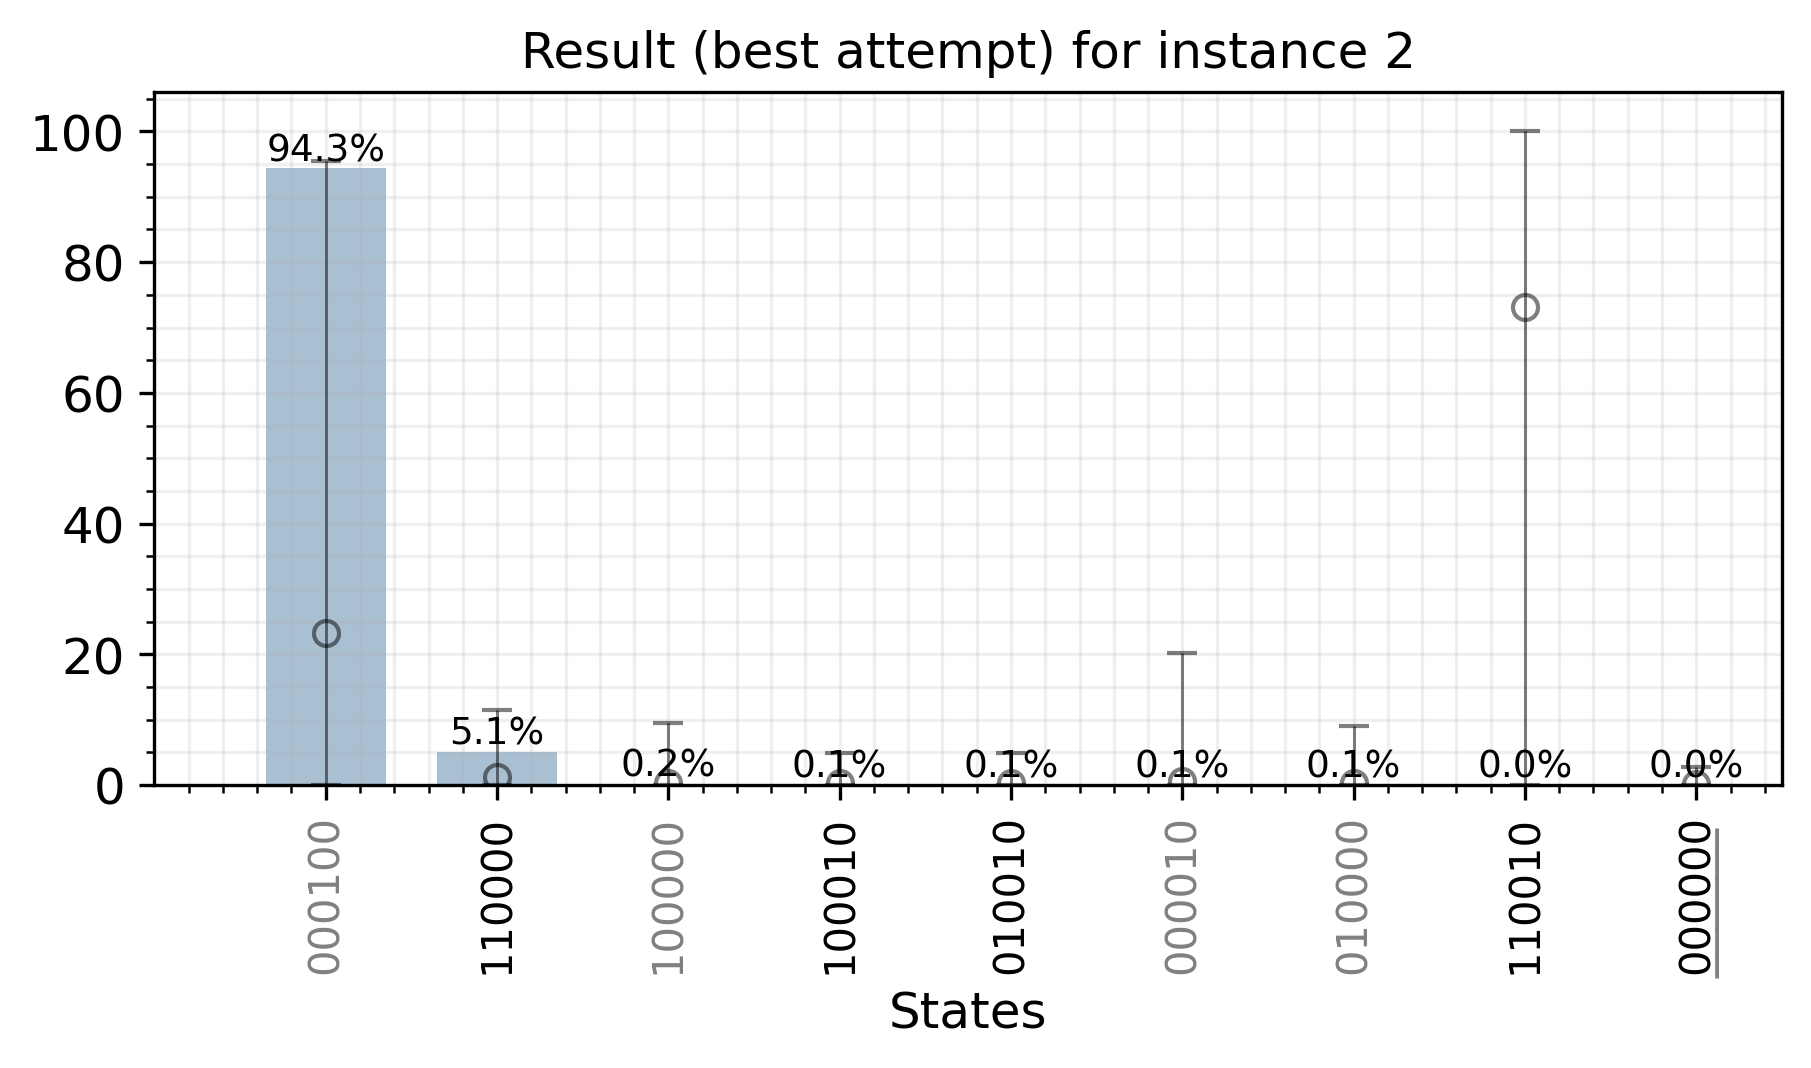

Result saved in:
random_parameters_2025-06-08@11h47m12s/dim6_mail2_all0_random_p4_50ra_k0.25_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432].csv
random_parameters_2025-06-08@11h47m12s/dim6_mail2_all0_random_p4_50ra_k0.25_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432]_data.txt

TOTAL ELAPSED TIME: 13.647169601917266 minutes.


In [13]:
current_datetime = datetime.now().strftime("%Y-%m-%d@%Hh%Mm%Ss")

# Create a  directory where to collect files
folder_path = f"random_parameters_{current_datetime}"
print(f"Saving in folder_path = {folder_path}")
os.makedirs(folder_path, exist_ok=True)

# Run QAOA+ for every instance.
for h, instance in zip(chosen_ks, chosen_instances):

    print("*"*50)
    print(f"Instance {instance} with h = {h}\n")

    FILENAME_list = [] # list of .csv containing the final histograms data.
    DATA_FILENAME_list = [] # list of .txt containing metadata such as energies, betas, gammas.


    # Define the instance.
    U, subsets_dict = define_instance(n, instance, info_dim6, verbose=False)
    subsets = list(subsets_dict.values())
    _, _, _, _, EXACT_COVERS = find_spectrum(U, subsets_dict, n, h)
    MEC = [state for state in EXACT_COVERS if state.count("1") == min([x.count("1")  for x in EXACT_COVERS])]

    print("U, subsets, EXACT_COVERS, MEC", U, subsets, EXACT_COVERS, MEC)

    # Plot states vs energy.
    show_spectrum(n, instance, h, info_dim6, fontsize=10)


    # Choose the initialization.
    if init_string == 'all1':
        # Only "1"-states.
        init_name = ["".join(elem) for elem in distinct_permutations('0'*(n-1) + '1')]

    elif init_string == 'all0':
        init_name = ["000000"]


    # Prepare the cost and mixing circuit.
    constant, hamiltonian, qc_cost = build_cost_circuit(n, instance, h, info_dim6, verbose=False)
    qc_mixing = build_mixing_circuit(n, instance, info_dim6, verbose=False)
    qc_initial, check_counts  = build_initialization_circuit(n, instance, init_name, info_dim6, verbose=False)

    # # Check that initialization was correct.
    # plot_histogram(check_counts, ax=plt.subplots()[1], title="Initialization check", color='k')
    # plt.show(block=False) # don't stop execution


    # Set initial angles.
    gamma_bound = find_gamma_bound(n, instance, h, info_dim6, verbose=False)

    beta_0 = (0, 2*np.pi)
    gamma_0 =  (-gamma_bound, gamma_bound)
    string_0 = f"[0,2pi]x[-{gamma_bound},{gamma_bound}]"

    bnds_beta = (0, 2*np.pi)
    bnds_gamma = (-gamma_bound, gamma_bound)
    bnds_string = f"[0,2pi]x[-{gamma_bound},{gamma_bound}]"


    # Build files' names.
    header = f"dim{n}_mail{instance}_{init_string}" \
           + f"_random_p{p}_{random_attempts}ra_k{h}" \
           + f"_BOUNDS{bnds_string}_pars0{string_0}"

    FILENAME = os.path.join(folder_path, header + f".csv")
    DATA_FILENAME = os.path.join(folder_path, header + f"_data.txt")

    FILENAME_list.append(FILENAME)
    DATA_FILENAME_list.append(DATA_FILENAME)


    # Record the details of each attempt in a file.
    with open(DATA_FILENAME, 'a') as DATA_FILE:
        write_params_on_file(DATA_FILE, params) # Write global parameters

        E_best = 100
        TOTAL_start_time = time.time()

        for attempt in range(1,random_attempts+1):
            print(f"\n---------- {attempt}/{random_attempts} random_attempts -----------\n")
            DATA_FILE.write(f"\n---------- {attempt}/{random_attempts} random_attempts -----------\n")

            # Build QAOAAnsatz.
            cost_vs_iteration = [] # to save (and plot) iterations
            ansatz = QAOAAnsatz(qc_cost,
                                mixer_operator=qc_mixing,
                                initial_state=qc_initial,
                                reps=p, name='QAOA+')


            # Generate a pass manager without providing a backend.
            pm = generate_preset_pass_manager(optimization_level=3)
            ansatz_isa = pm.run(ansatz)
            hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)

            estimator = StatevectorEstimator()
            sampler = StatevectorSampler()


            # *************************  FIND OPTIMAL ANGLES  ***************************
            # *************************     THROUGH QAOA+     ***************************

            # Set initial angles and angles'bounds.
            pars_0 = [random.uniform(*beta_0) for _ in range(p)] + \
                     [random.uniform(*gamma_0) for _ in range(p)]
            bnds = [bnds_beta]*p + [bnds_gamma]*p

            print(f"pars_0 = {pars_0}")
            print(f"bnds = {bnds}\n")


            # Do the minimization.
            result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations
                              pars_0, bounds=bnds,
                              args=(ansatz_isa, hamiltonian_isa, estimator),
                              method="Nelder-Mead",
                              options={"disp": True, "maxiter": 1200, "maxfev": 1200}, tol=1e-4)


            # Works only if you chose cost_func_plot.
            if cost_vs_iteration != []:
                plt.figure()
                plt.plot(cost_vs_iteration)
                plt.xlabel("Iteration")
                plt.ylabel("Cost")
                plt.show()


            # Minimum energy reached with minimization.
            E_min = result.fun + constant
            print(f"E_min = result.fun + constant = {E_min}")
            print(f"E_min = result.fun = {result.fun}")
            DATA_FILE.write(f"\nE_min = {E_min}")


            # Optimal parameters (betas, gammas) found.
            betas = list(result.x[:p])
            gammas = list(result.x[p:])
            print(f"\nOptimal parameters: betas, gammas = {betas}, {gammas}")
            DATA_FILE.write(f'\nE_min\'s parameters: betas = {betas}, gammas = {gammas}\n')


            # Update the best attempt.
            if E_min < E_best:
                    E_best = E_min
                    best_attempt = attempt
                    print("--> ***UPDATING THE BEST ATTEMPT***\n")
            else:
                print("--> ***NOT UPDATING THE BEST ATTEMPT***\n")


            # ****************************  RUN THE CIRCUIT  ******************************
            # ************************ WITH OPTIMAL PARAMETERS ****************************

            # Assign to the previously created ansatz the 2p parameters found.
            pars = betas + gammas
            qc = ansatz.assign_parameters(pars)
            qc.measure_all() # add a measurement

            # Run this circuit.
            qc_isa = pm.run(qc)
            output = sampler.run([qc_isa], shots=1024).result()
            samp_dist = output[0].data.meas.get_counts()


            # ****************************  POST PROCESS  **********************************
            # *********************** AND SAVE THE OUTPUT HISTOGRAM ************************

            # Create a dataframe from the sampling results.
            df = pd.DataFrame(samp_dist.items(), columns=['states', 'counts'])

            # Remove ancillary bits.
            num_ancillas = get_circuit_parameters(subsets, verbose=False)[2]
            df['states'] = df['states'].apply(lambda x: x[num_ancillas:])

            # Invert the bit order for the states (e.g., convert "01101" to "10110").
            df['states'] = df['states'].apply(lambda s: str(s)[::-1])  # Invertiamo l'ordine dei bit

            # After removing the ancillary bits, we aggregate counts by state.
            df = df.groupby(['states']).sum().reset_index()

            # Sort in decreasing order.
            df = df.sort_values('counts', ascending=False)

            # Rename the "counts" column to include attempt details.
            df.columns = ['states', f'counts_p{p}_{attempt}of{random_attempts}']

            # Merge the current attempt dataframe with previously built dataframes.
            if attempt == 1:
                df_all_attempts = df
            else:
                df_all_attempts = pd.merge(df_all_attempts, df, on="states", how="outer")
            
            print(df)


        # Save to .csv the global dataframe.
        df_all_attempts.to_csv(FILENAME, index=False)


        # Plot the best attempt (minimum energy), with error bars
        # representing other attempts in the global dataframe.
        plot_histogram_of_best_column(df_all_attempts,
                                      f'counts_p{p}_{best_attempt}of{random_attempts}',
                                      EXACT_COVERS, init_name,
                                      fontsize=12, title=f"Result (best attempt) for instance {instance}")


        DATA_FILE.write("\n*******************************")
        DATA_FILE.write(f"\nAttempt that reached the best result with E_min = {E_best} is #{best_attempt} ")
        DATA_FILE.write(f"\nTOTAL ELAPSED TIME: {(time.time() - TOTAL_start_time)/60} minutes.\n")
        print(f"Result saved in:\n{FILENAME}\n{DATA_FILENAME}")
        print(f"\nTOTAL ELAPSED TIME: {(time.time() - TOTAL_start_time)/60} minutes.")

## (Optional) Draw the latest instance QAOA circuit

In [8]:
print(f"Instance #{instance}")
ansatz.decompose(reps=2).draw("mpl")

Instance #1


NameError: name 'ansatz' is not defined

## Plot from a saved folder ...
### ... for each instance, the best attempt (with also mean and error displayed) or...
Plot the results of all chosen instances for which QAOA has been computed or plot results from a previous run.

The `find_files_containing_string` function will search for `.csv` and `.txt` files in the selected `path`. If provided, it will also search for files that contain a specific string of text.

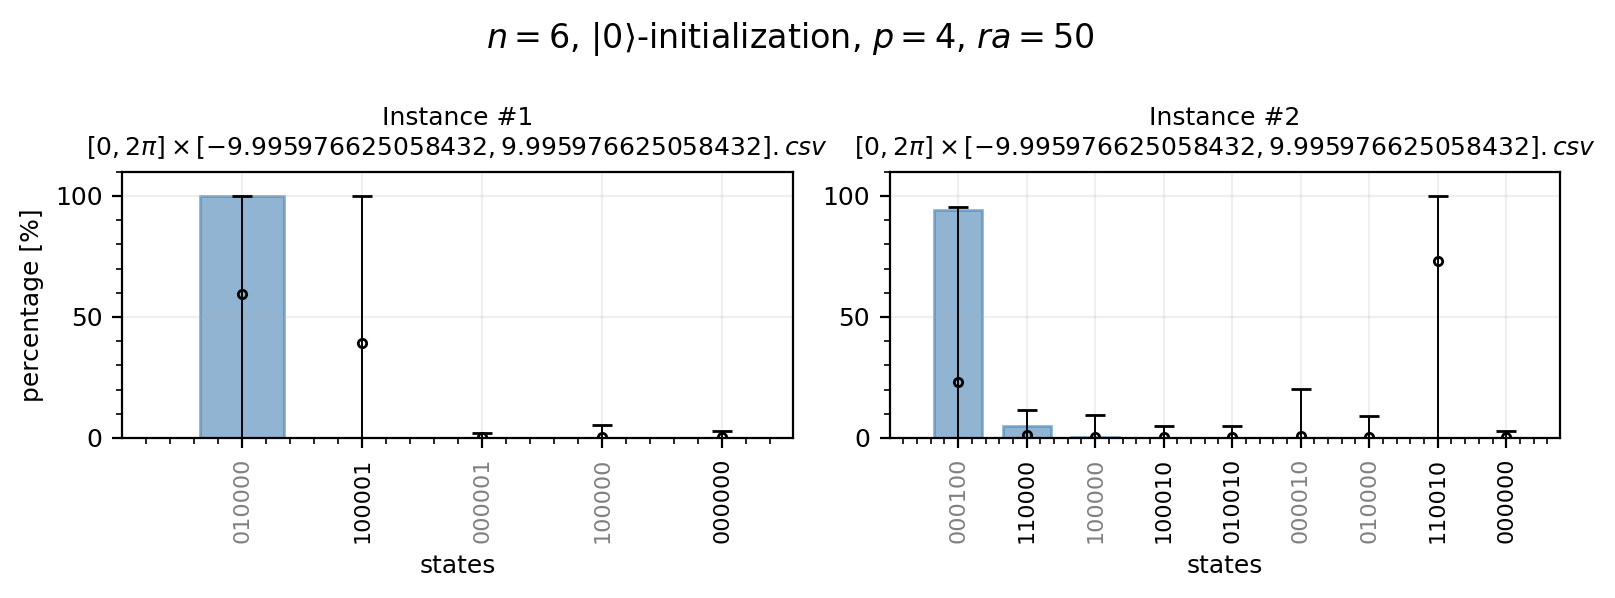

In [14]:
# Uncomment this line to plot data from an existing directory
# folder_path = "random_parameters_2025-01-30@09h03m50s"
# folder_path = "random_parameters_2025-06-06@17h36m57s"

# Find the files that contain every string in 'substrings'.
FILENAME_list, DATA_FILENAME_list = find_files_containing_string(path= f"./{folder_path}/")

# Get the number of files collected.
num_files = len(FILENAME_list)

if num_files>1:
    plot_list_of_files(FILENAME_list, DATA_FILENAME_list,
                       colorchosen="steelblue", alpha=0.6,
                       info=info_dim6,
                       init_name="all1",
                       dont_show_in_title=["i", "k"],
                       dont_show_in_titles=["n", "p", "ra", "k", "init"],
                       figsize=(8,num_files+1),
                       dpi=200, N=9) # figsize=(10, 13), dpi=300, N=12 for latex figures
else:
    plot_file(FILENAME_list[0], DATA_FILENAME_list[0],
              colorchosen='indigo', alpha=0.4,
              info=info_dim6,
              dont_show_in_title = [],
              figsize=(10,4), dpi=200, N=10)

### ... for each instance, every single attempt

In [ ]:
# folder_path = "random_parameters_2025-01-30@09h03m50s"
plot_each_attempt_from_folder(folder_path)

In [6]:
print(info_dim6)


{1: {'exact_covers': ['011110', '101111'], 'mec': '011110', 'subsets': [{8, 11}, {8, 11, 4, 12}, {10, 3}, {9, 2, 5, 7}, {1, 6}, {4, 12}]}, 2: {'exact_covers': ['001101', '111011'], 'mec': '001101', 'subsets': [{1, 5}, {4, 6}, {10, 7}, {1, 2, 4, 5, 6, 12}, {2, 12}, {8, 9, 3, 11}]}, 3: {'exact_covers': ['100111', '111011'], 'mec': '100111', 'subsets': [{12, 6}, {8, 1, 10, 4}, {3, 7}, {1, 3, 4, 7, 8, 10}, {9, 5}, {2, 11}]}, 4: {'exact_covers': ['001110', '111101'], 'mec': '001110', 'subsets': [{8, 1}, {12, 5}, {10, 7}, {2, 3, 4, 6}, {1, 5, 8, 9, 11, 12}, {9, 11}]}, 5: {'exact_covers': ['110001', '011111'], 'mec': '110001', 'subsets': [{1, 3, 5, 7, 8, 10}, {11, 4}, {5, 7}, {8, 3}, {1, 10}, {9, 2, 12, 6}]}, 6: {'exact_covers': ['001111', '111101'], 'mec': '001111', 'subsets': [{2, 10}, {9, 11, 4, 5}, {3, 12}, {1, 6}, {2, 4, 5, 9, 10, 11}, {8, 7}]}, 7: {'exact_covers': ['101001', '011111'], 'mec': '101001', 'subsets': [{1, 2, 7, 10, 11, 12}, {10, 12}, {3, 4}, {1, 2}, {11, 7}, {8, 9, 5, 6}]},